In [ ]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install np_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-z341pakf
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-z341pakf
  Resolved https://github.com/albumentations-team/albumentations to commit 1eceb794ccbf52a02b09e630833f61366bef1149
  Preparing metadata (setup.py) ... done
  Created wheel for albumentations: filename=albumentations-1.3.0-py3-none-any.whl size=125642 sha256=ed345f4e74a5ae933b6c7b4eb51c7533d0e400d7c483fbe8ff9123434d52e354
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmvicrpt/wheels/f3/4a/7f/67b055656bec4d4aaa8963cfc93678f6f2906b2d72054a1268
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1
L

In [ ]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import cv2, os, random
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, plot, iplot

#____________________________________________________________

import glob
import tensorflow
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split

#____________________________________________________________

from tqdm.notebook import tqdm
from termcolor import colored
import albumentations as A

#____________________________________________________________

from warnings import filterwarnings
filterwarnings("ignore")

from sklearn import set_config
set_config(print_changed_only = False)
directory = "../input/chest-xray-pneumonia/chest_xray/"

#____________________________________________________________

print(colored("Required libraries were succesfully imported...", color = "green", attrs = ["bold", "dark"]))

Required libraries were succesfully imported...
CPU times: user 4.59 s, sys: 721 ms, total: 5.32 s
Wall time: 8.8 s


In [ ]:
print(tensorflow.config.list_physical_devices("GPU"))

print("________________________________________________")

print(tensorflow.test.is_gpu_available(cuda_only = False, min_cuda_compute_capability = None))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]
________________________________________________
False


In [ ]:
print("Current tensorflow version == {}".format(tensorflow. __version__))

Current tensorflow version == 2.9.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time

train_df = glob.glob("/content/drive/MyDrive/Taiwan Intern/chest_xray/train/**/*.jpeg")
test_df = glob.glob("/content/drive/MyDrive/Taiwan Intern/chest_xray/test/**/*.jpeg")
validation_df = glob.glob("/content/drive/MyDrive/Taiwan Intern/chest_xray/val/**/*.jpeg")

print(colored("The datasets were succesfully loaded...", color = "green", attrs = ["bold", "dark"]))

The datasets were succesfully loaded...
CPU times: user 39.1 ms, sys: 4.08 ms, total: 43.1 ms
Wall time: 2.81 s


In [ ]:
train_df[:5], test_df[:5]

(['/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0511-0001-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0523-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0520-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0523-0001-0002.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0509-0001-0001.jpeg'],
 ['/content/drive/MyDrive/Taiwan Intern/chest_xray/test/NORMAL/IM-0003-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/test/NORMAL/IM-0019-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/test/NORMAL/IM-0016-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/test/NORMAL/IM-0017-0001.jpeg',
  '/content/drive/MyDrive/Taiwan Intern/chest_xray/test/NORMAL/IM-0006-0001.jpeg'])

In [ ]:
print("There is {} images in the training dataset".format(len(train_df)))
print("There is {} images in the test dataset".format(len(test_df)))
print("There is {} images in the validation dataset".format(len(validation_df)))

There is 5224 images in the training dataset
There is 624 images in the test dataset
There is 16 images in the validation dataset


In [ ]:
datasets, pneumonia_lung, normal_lung = ["train", "test", "val"], [], []

for i in datasets:
    path = os.path.join(directory, i)
    normal = glob.glob(os.path.join(path, "/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/*.jpeg"))
    pneumonia = glob.glob(os.path.join(path, "/content/drive/MyDrive/Taiwan Intern/chest_xray/train/PNEUMONIA/*.jpeg"))
    normal_lung.extend(normal), pneumonia_lung.extend(pneumonia)

print("The number of pneumonia images is {}".format(len(pneumonia_lung)))
print("The number of non-pneumonia images is {}".format(len(normal_lung)))

The number of pneumonia images is 11625
The number of non-pneumonia images is 4047


In [ ]:
random.shuffle(normal_lung)
random.shuffle(pneumonia_lung)
images = normal_lung[:50] + pneumonia_lung[:50]
images[:10]

['/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0738-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0235-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/NORMAL2-IM-1103-0001-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/NORMAL2-IM-1102-0001-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0562-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/NORMAL2-IM-1226-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/NORMAL2-IM-0585-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0642-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0619-0001.jpeg',
 '/content/drive/MyDrive/Taiwan Intern/chest_xray/train/NORMAL/IM-0441-0001.jpeg']

NORMAL


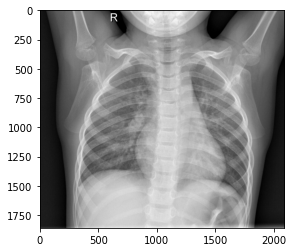

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/Taiwan Intern/chest_xray/chest_xray/train/NORMAL/IM-0115-0001.jpeg")
print("NORMAL")
plt.imshow(normal_lung_image)
plt.show()

PNEUMONIA


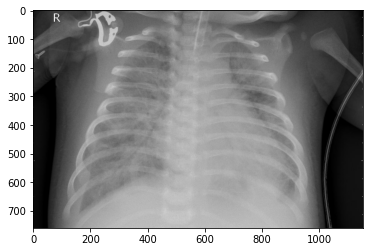

In [ ]:
normal_lung_image = load_img("/content/drive/MyDrive/Taiwan Intern/chest_xray/chest_xray/train/PNEUMONIA/person1000_bacteria_2931.jpeg")
print("PNEUMONIA")
plt.imshow(normal_lung_image)
plt.show()

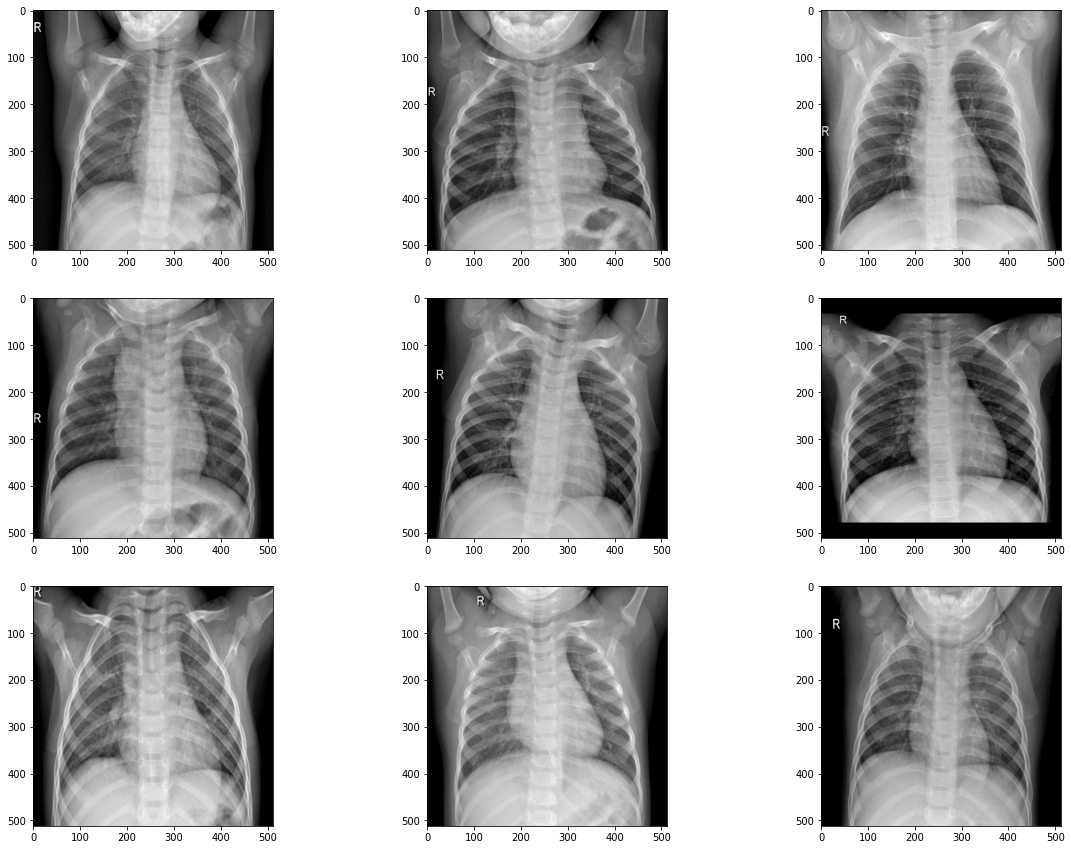

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

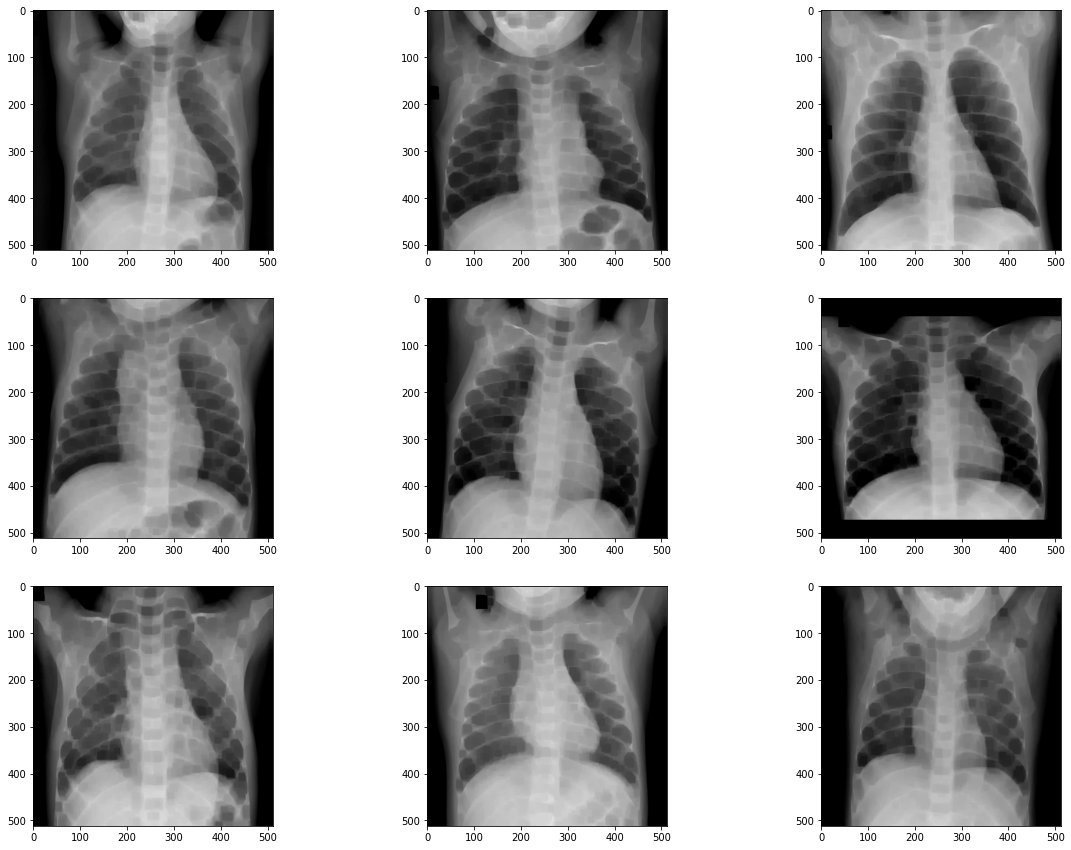

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3
for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_erosion)

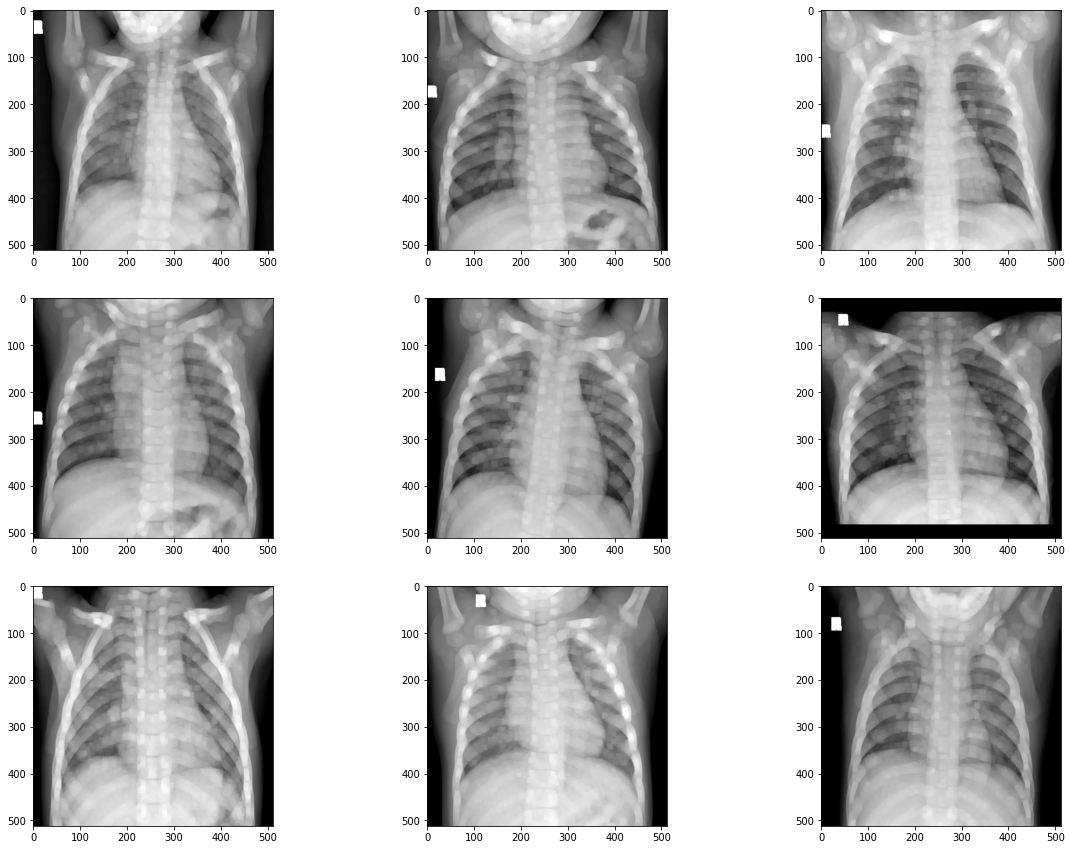

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    image_dilation = cv2.dilate(img, kernel, iterations = 2)
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_dilation)

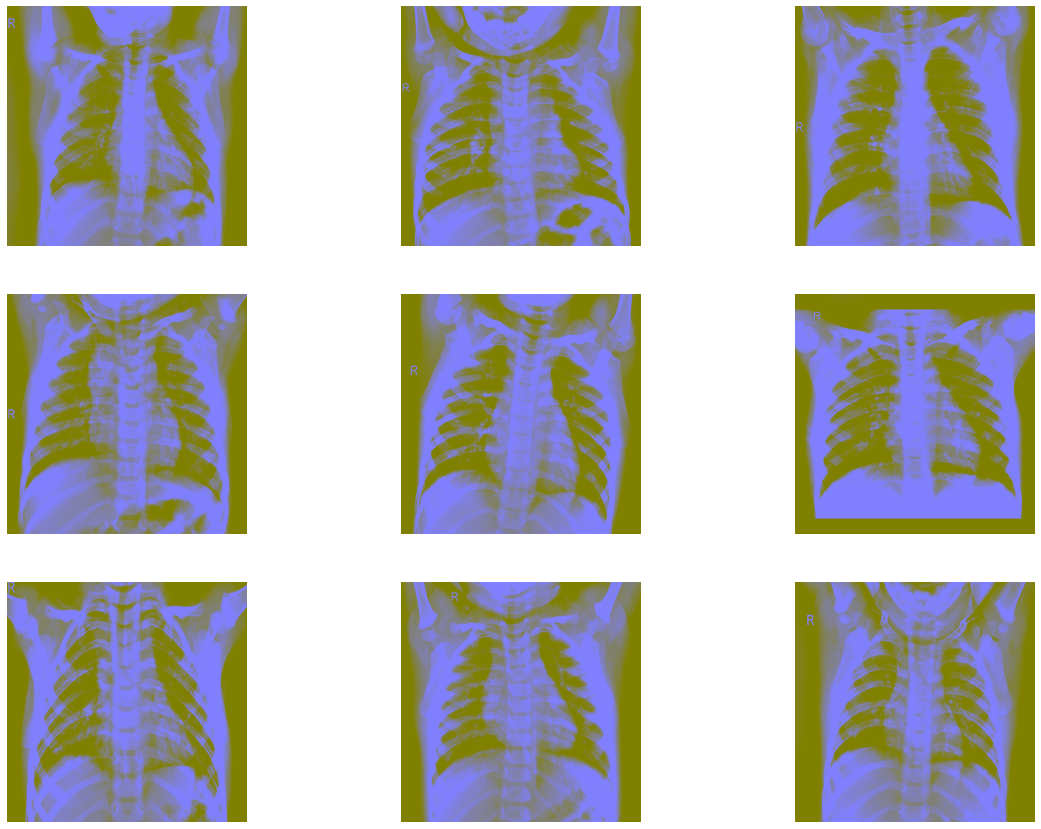

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0, 0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

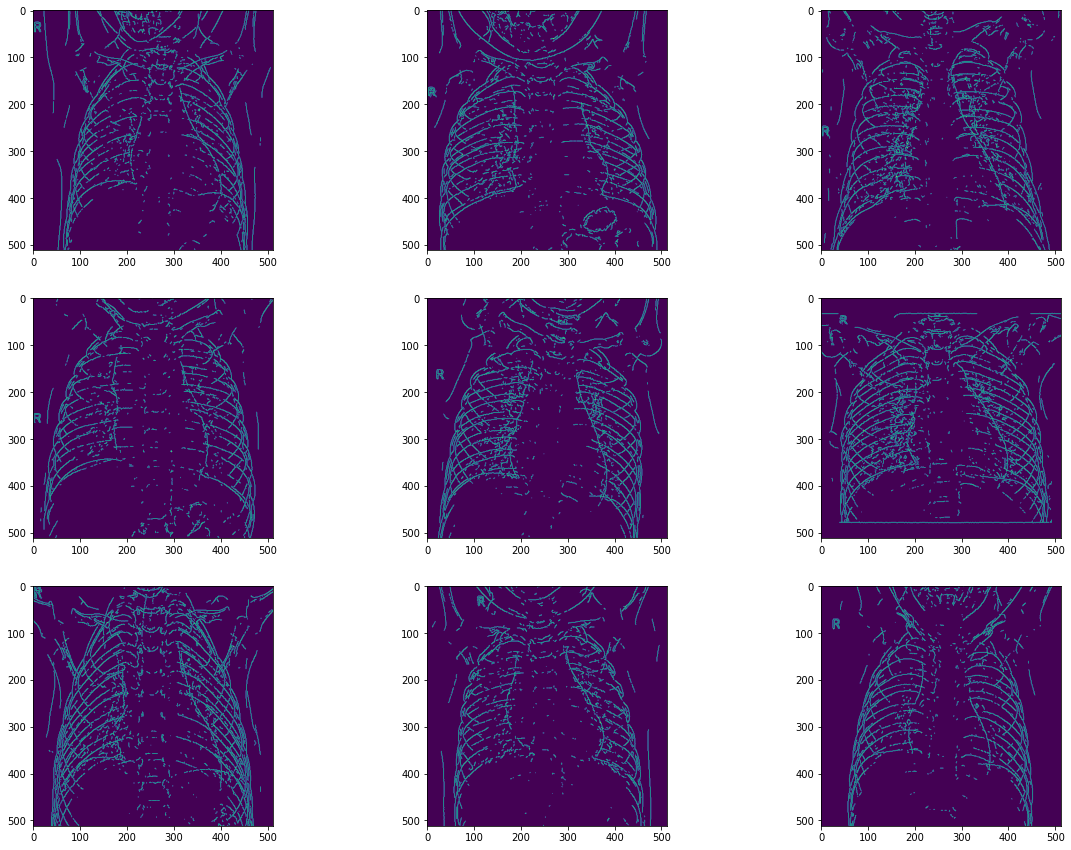

In [ ]:
fig = plt.figure(figsize = (20, 15))
columns, rows = 3, 3

for i in range(1, 10):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detected_edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(detected_edges)

In [ ]:
train_dir = "/content/drive/MyDrive/Taiwan Intern/chest_xray/chest_xray/train"
test_dir = "/content/drive/MyDrive/Taiwan Intern/chest_xray/chest_xray/test"
validation_dir = "/content/drive/MyDrive/Taiwan Intern/chest_xray/chest_xray/val"

In [ ]:
%%time

train_datagen = ImageDataGenerator(
            rescale = 1/255.,
            horizontal_flip = True,
            vertical_flip = True,
            rotation_range = 0.3,
            zca_whitening = True,
            width_shift_range = 0.25,
            height_shift_range = 0.25,
            channel_shift_range = 0.35,
            shear_range = 0.2,
            zoom_range = 0.4)

val_test_datagen = ImageDataGenerator(rescale = 1./255)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 16, target_size = (224, 224))

Found 5226 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
CPU times: user 156 ms, sys: 7.7 ms, total: 163 ms
Wall time: 254 ms


In [ ]:
model1 = Sequential()

#convolutional neural networks - CNNs
model1.add(Conv2D(32, (3,3), strides = (1, 1),activation = "relu", padding = "same", input_shape = (224, 224, 3)))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(64, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Conv2D(128, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Conv2D(256, (3,3), strides = (1, 1), padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = (2, 2)))
model1.add(Dropout(0.2))
model1.add(Flatten())

#fully connected layer
model1.add(Dense(128, activation = "relu"))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(32, activation = "relu"))
model1.add(Dense(1, activation = "sigmoid"))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 56, 56, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       7

In [ ]:
model1.compile(optimizer = "rmsprop", loss = "binary_crossentropy", metrics = ["accuracy"])

In [ ]:
%%time

early_stopping_callbacks = tensorflow.keras.callbacks.EarlyStopping(patience = 15,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)

CPU times: user 69 µs, sys: 5 µs, total: 74 µs
Wall time: 79.2 µs


In [ ]:
%%time

history = model1.fit_generator(train_set, epochs = 20,
                              validation_data = validation_set,
                              steps_per_epoch = 100,
                              callbacks = [early_stopping_callbacks])

Epoch 1/20
100/100 [==============================] - 401s 4s/step - loss: 0.6577 - accuracy: 0.7431 - val_loss: 0.6348 - val_accuracy: 0.5000
Epoch 2/20
100/100 [==============================] - 326s 3s/step - loss: 0.4736 - accuracy: 0.7450 - val_loss: 0.8533 - val_accuracy: 0.5000
Epoch 3/20
100/100 [==============================] - 304s 3s/step - loss: 0.4338 - accuracy: 0.7862 - val_loss: 0.6101 - val_accuracy: 0.6250
Epoch 4/20
100/100 [==============================] - 307s 3s/step - loss: 0.3758 - accuracy: 0.8238 - val_loss: 0.5802 - val_accuracy: 0.7500
Epoch 5/20
100/100 [==============================] - 301s 3s/step - loss: 0.3681 - accuracy: 0.8306 - val_loss: 0.8474 - val_accuracy: 0.6875
Epoch 6/20
100/100 [==============================] - 303s 3s/step - loss: 0.3840 - accuracy: 0.8225 - val_loss: 1.0045 - val_accuracy: 0.6250
Epoch 7/20
100/100 [==============================] - 295s 3s/step - loss: 0.3644 - accuracy: 0.8394 - val_loss: 1.1660 - val_accuracy: 0.6250

In [ ]:
model1.input, model1.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'conv2d_input')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_3')>)

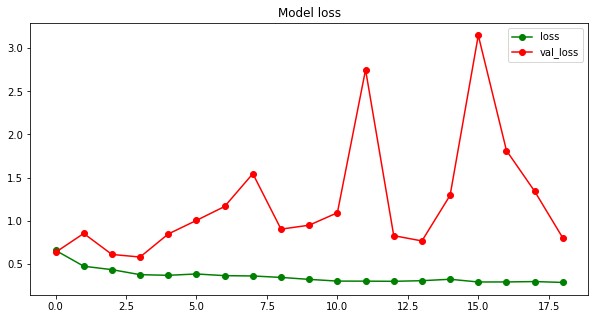

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

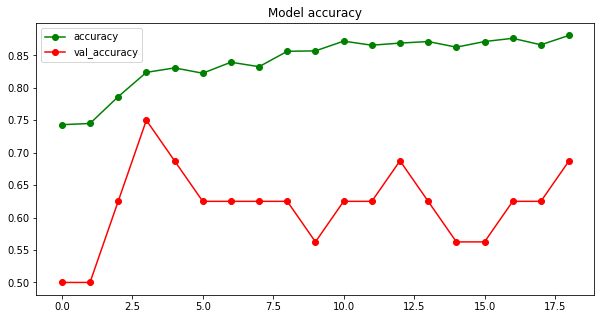

In [ ]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")

plt.plot(history.history["accuracy"], "go-")
plt.plot(history.history["val_accuracy"], "ro-")
plt.legend(["accuracy", "val_accuracy"])
plt.show()


In [ ]:
#scores = model1.evaluate_generator(test_set)
#print("\n%s: %.3f%%" % (model1.metrics_names[0], scores[0]*100))
#print("\n%s: %.3f%%" % (model1.metrics_names[1], scores[1]*100))

test_loss, test_accuracy = model1.evaluate(test_set, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

39/50 [======================>.......] - ETA: 29s - loss: 0.4854 - accuracy: 0.8045

50/50 [==============================] - 106s 2s/step - loss: 0.4854 - accuracy: 0.8045
The testing accuracy is:  80.44871687889099 %
The testing loss is:  48.54378402233124 %
